In [20]:
import matplotlib.pyplot as plt

import numpy as np
import librosa
from librosa import display
from scipy.io import wavfile
import seaborn as sns

#### Загрузка аудио сэмплов

Signal length: 441000 samples
Sample rate  : 44100 samples per second
Duration     : 10.0 seconds
Min: -0.98618
Max: 0.99997
Mean: -3.4452e-05


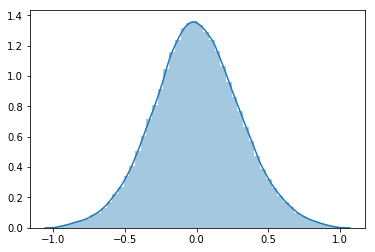

In [849]:
y, sr = librosa.load("Way.mp3", sr=None, offset=20, duration=10)
# y, sr = librosa.load("Lune.mp3", sr=None, offset=0, duration=1)
# y, sr = librosa.load("C2.wav", sr=None)
# C.shape, sr, np.max(C)

print("Signal length: {} samples".format(len(y)))
print("Sample rate  : {} samples per second".format(sr))
print("Duration     : {} seconds".format(len(y)/sr))
print("Min: {:.5}".format(np.min(y)))
print("Max: {:.5}".format(np.max(y)))
print("Mean: {:.5}".format(np.mean(y)))

sns.distplot(y)
# plt.plot(y[:200])

#### Настройки для CQT преобразования

In [850]:
# инвариант k*res > 6
k = 12    # число бинов на каждую ноту 
res = 1   # коэф ресэмплинга
fk = 1    # масштабирование фильтров
keys = 12 # число нот в октаве
bins_per_octave = keys*k  # число бинов на каждую октаву 
sr_resampled = sr*res     # sample rate после ресэмплинга
n_octaves = 9             # число октав
n_bins = n_octaves*keys*k # числло бинов на все октавы
hop_length = 256

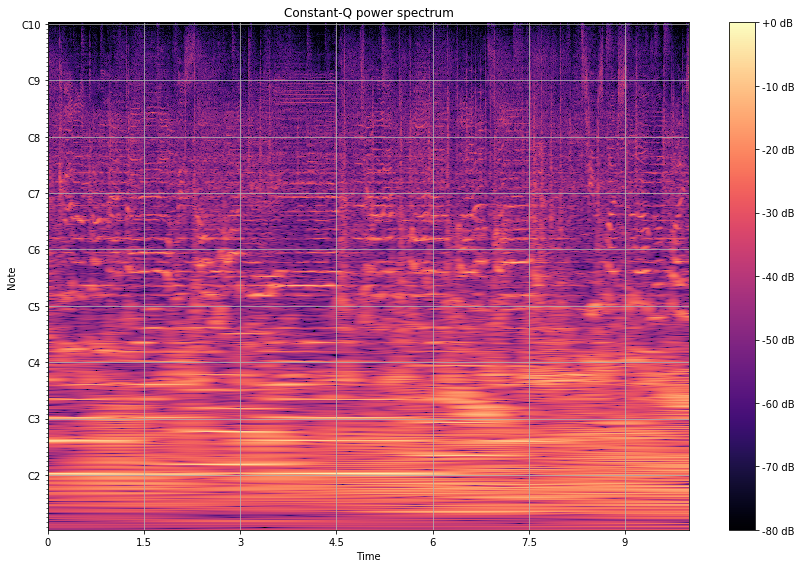

In [851]:
if res == 1:
    y_cqt = librosa.cqt(y, sr=sr, bins_per_octave=bins_per_octave, n_bins=n_bins, hop_length=hop_length, filter_scale=1/fk)
else:
    y_resampled = librosa.resample(y, sr, sr_resampled)
    y_cqt = librosa.cqt(y_resampled, sr=sr_resampled, bins_per_octave=bins_per_octave, n_bins=n_bins, hop_length=hop_length, filter_scale=1/fk)
y_cqt_abs = np.abs(y_cqt)
plt.figure(figsize=(12, 8))
display.specshow(librosa.amplitude_to_db(y_cqt_abs, ref=np.max), sr=sr_resampled*2, x_axis='time', y_axis='cqt_note', bins_per_octave=bins_per_octave) 

plt.colorbar(format='%+2.0f dB')
plt.grid()
plt.title('Constant-Q power spectrum')
plt.tight_layout()

# y_icqt_hat_resampled = librosa.icqt(C=y_cqt, sr=sr_resampled, bins_per_octave=bins_per_octave, hop_length=hop_length, filter_scale=1/fk)

# y_icqt_hat = librosa.resample(y_icqt_hat_resampled, sr_resampled, sr)
y_icqt_hat = librosa.icqt(C=y_cqt, sr=sr, bins_per_octave=bins_per_octave, hop_length=hop_length, filter_scale=1/fk)

wavfile.write('file__9.wav', rate=sr, data=y_icqt_hat)
wavfile.write('file_9.wav', rate=sr, data=y)

# wavfile.write('file__9.wav', rate=sr*res, data=y_hat)

In [852]:
y_stft_phase = np.angle(y_cqt)
ff = fullPhase(y_stft_phase)
sidff = np.zeros(ff.shape)
for i in range(sidff.shape[0]):
    sidff[i] += ifConst(i)
siidff = np.cumsum(sidff, axis = 1)
siidff = siidff % (2*np.pi) - np.pi

In [853]:
np.min(siidff), np.max(siidff)

(-3.1415799433753158, 3.1415612483103637)

In [854]:
# y_cqt.imag, siidff
# np.min(y_cqt.imag), np.max(y_cqt.imag) , np.min(siidff), np.max(siidff)
sy_cqt = y_cqt_abs*np.exp(1j*siidff)
# 1*np.exp((1j)*(np.pi/2))
sy = librosa.icqt(C=sy_cqt, sr=sr, bins_per_octave=bins_per_octave, hop_length=hop_length, filter_scale=1/fk)
wavfile.write('file_9_.wav', rate=sr, data=sy)

In [855]:
ssiidff = iidff % (2*np.pi) - np.pi
ssy_cqt = y_cqt_abs[:,2:]*np.exp(1j*ssiidff)
ssy = librosa.icqt(C=ssy_cqt, sr=sr, bins_per_octave=bins_per_octave, hop_length=hop_length, filter_scale=1/fk)
wavfile.write('file_9__.wav', rate=sr, data=ssy)
# np.min(ssiidff), np.max(ssiidff)

In [846]:
y.shape, sy.shape

((441000,), (440832,))

#### STFT преобразование

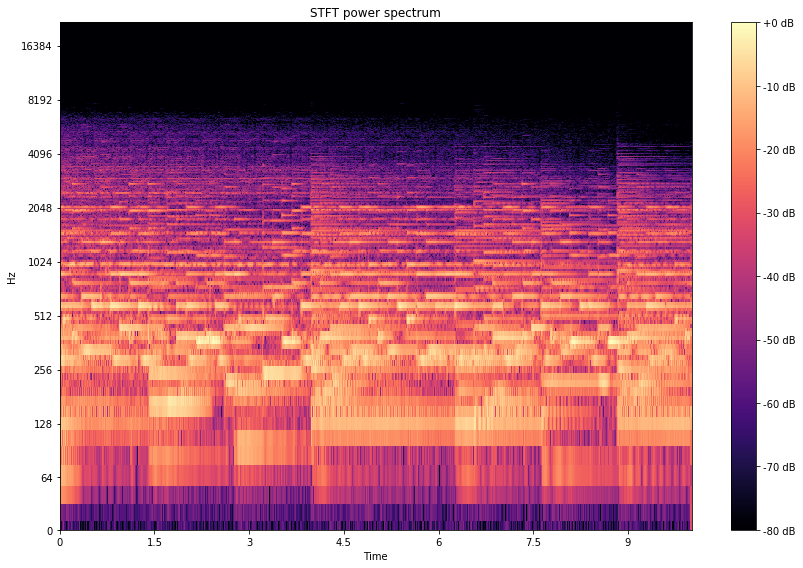

In [430]:
y_stft = librosa.stft(y, hop_length=512, n_fft=2048)
y_stft_abs = np.abs(y_stft)
plt.figure(figsize=(12, 8))
display.specshow(librosa.amplitude_to_db(y_stft_abs, ref=np.max), sr=sr, y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('STFT power spectrum')
plt.tight_layout()

# y_istft_hat = librosa.istft(y_stft_abs, hop_length=64)
# wavfile.write('file__.wav', rate=sr, data=y_istft_hat)

In [504]:
def ifFromPhase(phase):
    dims = phase.shape
    if_ = phase.copy()
    for i in range(dims[0]):
        for j in range(1, dims[1]):
            if_[i][j] = phase[i][j]-phase[i][j-1]
            if if_[i][j] < 0:
                if_[i][j] = if_[i][j] + 2*np.pi
        if_[i][0] = if_[i][1]
    if__ = if_.copy()
    for i in range(dims[0]):
        if__[i][0] = 0
        for j in range(1, dims[1]):
            if__[i][j] = if_[i][j]-if_[i][j-1]
    return if_

In [457]:
def fullPhase(phase):
    dims = phase.shape
    if_ = phase.copy()
    for i in range(dims[0]):
        for j in range(1, dims[1]):
            if phase[i][j]-phase[i][j-1] < 0:
                if_[i][j:] += 2*np.pi # + if_[i][j] 
    return if_

In [891]:
def ifConst(i):
#     return (2**((i+36.0)/144))%(2*np.pi)
    return (2**((i+36.62853230372156)/144))%(2*np.pi)

#### Полная фаза

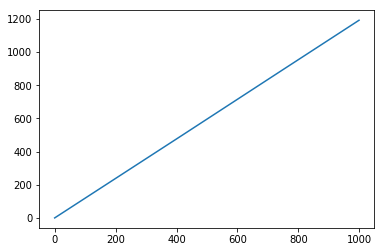

In [788]:
# y_stft_phase = np.angle(y_stft)
y_stft_phase = np.angle(y_cqt)
ff = fullPhase(y_stft_phase)
plt.plot(range(y_stft_phase.shape[1])[:1000], ff[0][:1000])

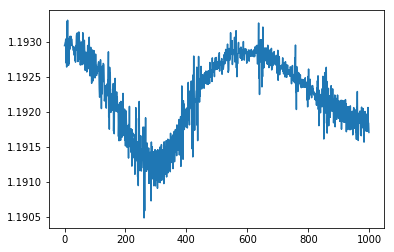

In [885]:
# # y_stft_phase = np.angle(y_stft)
y_stft_phase = np.angle(y_cqt)
if_ = ifFromPhase(ff)
plt.plot(range(y_stft_phase.shape[1])[:1000], if_[0][:1000])

#### Вторая произовдная

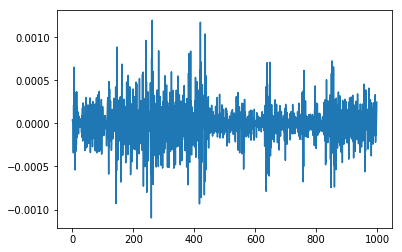

In [924]:
dff_ = np.diff(ff)
dff = np.diff(ff,2)
plt.plot(range(y_stft_phase.shape[1])[:1000], dff[0][:1000])

#### Первая производная

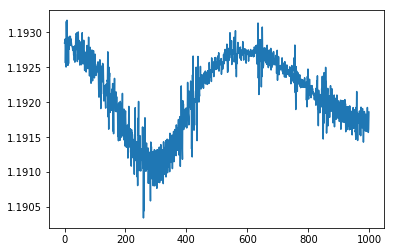

In [893]:
idff = np.cumsum(dff, axis = 1)
for i in range(idff.shape[0]):
    idff[i] += ifConst(i)
plt.plot(range(y_stft_phase.shape[1])[:1000], idff[0][:1000])

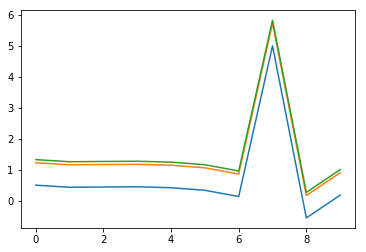

In [928]:
num = 910
lim = 10
plt.plot(range(y_stft_phase.shape[1])[:lim], idff[num][:lim], range(y_stft_phase.shape[1])[:lim], if_[num][2:2+lim], range(y_stft_phase.shape[1])[:lim], dff_[num][1:1+lim]+0.1)

#### Интегрированная фаза

45.96032318644575
13.166637985969068


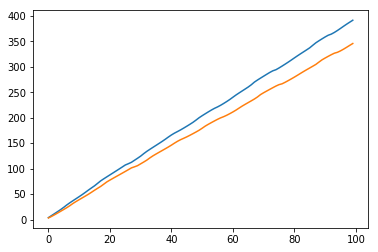

In [806]:
iidff = np.cumsum(idff, axis = 1)
lim = 100
num = 915
plt.plot(range(y_stft_phase.shape[1])[:lim], iidff[num][:lim], range(y_stft_phase.shape[1])[:lim], ff[num][:lim])
print(iidff[num][lim]-ff[num][lim])
print((iidff[num][lim]-ff[num][lim])/ff[num][lim]*100)

-12.389990320610309
-3.549464100575496


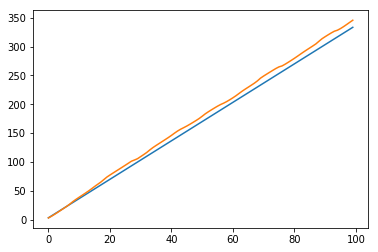

In [805]:
sidff = np.zeros(ff.shape)
for i in range(sidff.shape[0]):
    sidff[i] += ifConst(i)
siidff = np.cumsum(sidff, axis = 1) 
lim = 100
num = 915
plt.plot(range(y_stft_phase.shape[1])[:lim], siidff[num][:lim], range(y_stft_phase.shape[1])[:lim], ff[num][:lim])
print(siidff[num][lim]-ff[num][lim])
print((siidff[num][lim]-ff[num][lim])/ff[num][lim]*100)

In [794]:
idff.shape, ff.shape

((1296, 1721), (1296, 1723))

In [743]:
def ifConst(i):
    return (2.0**((i+36.62853230372156)/144))%(2*np.pi)
bf = librosa.cqt_frequencies(24, fmin=librosa.note_to_hz('C5'))[0]
print(bf)
ibf = 1/bf
print(ibf)
ssr = 44100/256/1
isr = 1/ssr
print(isr)
print(isr/ibf*2*np.pi)
print(ifConst(144*4))

523.2511306011972
0.001911128216485715
0.005804988662131519
19.08496727515167
0.2354113536129141


0
-0.0001351500123081273
0.002962228866011163
0.010885021323427946
-0.013884556626968969
0.00031544133706118416
-0.00041341771530256644
-0.014317496596248702
-0.03252829400093526
0.0037947494199532805
0.013002743941013417
0.011017298860996672
-0.007126044273501719
-0.004297236351378244
0.0027908949188120147
0.0022323223457734187
-0.006181667179253836
0.7885240566895896
-0.0214735412577598
0.0022505786855333554
-0.01636229665528221
-0.021683190090008964
-0.030115012571141797
0.009711126998453778
0.030903548504493727
-0.0024211716300941433
0.03290683527520155
0.014854806337361026
-0.07589886984635541
-0.04662936720658273
-0.03290383350626325
0.021435391468854537
-0.12054511584911332
-0.16789833372759408
0.06735835761055452
0.004785741031033903
-0.09899997182138119
0.10262219951791351
0.33143164002175496
0.19837506723446507
-0.07686897583610983
0.373295201636834
-0.03579724283550778
-0.3958520692325073
-0.464618688655027
0.1472476855177556
0.1943919577411828
-0.004593664534953135
-0.22161

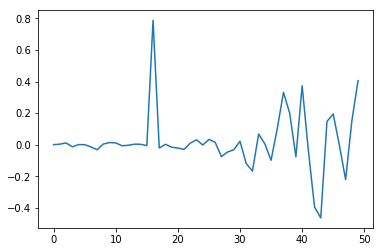

In [904]:
num = 1000
ccc = []
ko=20
for j in range(1):
    print(j)
    def ifConst(i):
        return ((2)**((i+36.62853230372156)/144))%(2*np.pi)
    idff = np.cumsum(dff, axis = 1)
    for i in range(idff.shape[0]):
        idff[i] += ifConst(i)
    iidff = np.cumsum(idff, axis = 1)
    i = 144*1
#     plt.plot(range(y_stft_phase.shape[1])[:100], idff[i][:100],
#              range(y_stft_phase.shape[1])[:100], if_[i][2:100+2])
#     print(idff[i][0] - if_[i][2])
    for i in range(50):
        ccc.append(np.mean(idff[i*ko][0:num] - if_[i*ko][2:num+2]))
        print(ccc[-1])
#         print((idff[i*144][0:num] - if_[i*144][2:num+2])-(idff[(i+1)*144][0:num] - if_[(i+1)*144][2:num+2]))
plt.plot(ccc)

In [487]:
ff.shape, dff.shape, idff.shape

((1296, 1723), (1296, 1721), (1296, 1721))

#### Производная мгновенной фазы

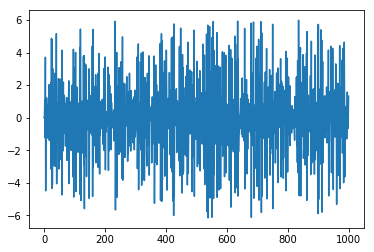

In [436]:
# y_stft_phase = np.angle(y_stft)
y_stft_phase = np.angle(y_cqt)
if_ = ifFromPhase(y_stft_phase)
plt.plot(range(y_stft_phase.shape[1])[:1000], if_[1200][:1000])

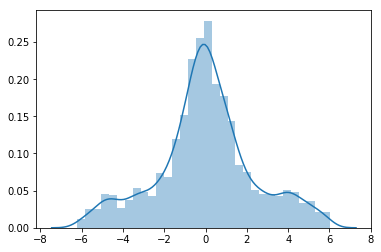

In [435]:
sns.distplot(if_[1200])

In [421]:
lo = []
av = []
rr = range(0,144*5)
for i in rr:
#     lo.append(np.log(np.average(if_[i,1:100])))
#     lo.append(np.average(if_[i,1:200]+np.pi*0)/2**((i%350)/144))
    lo.append(np.average(if_[i,1:1000])-(2**((i+36.5)/144))%(2*np.pi))
#     lo.append(np.average(if_[i,1:1000]))
#     av.append((2**((i+36.5)/144))%(2*np.pi))

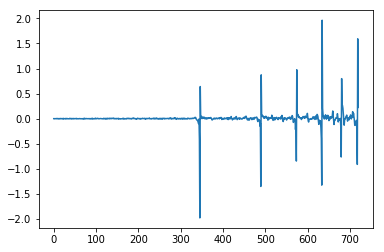

In [284]:
plt.plot(rr,lo)
# plt.plot(rr,av, rr,lo)

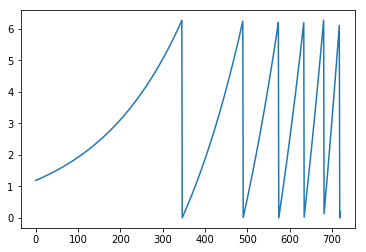

In [223]:
plt.plot(rr,av)

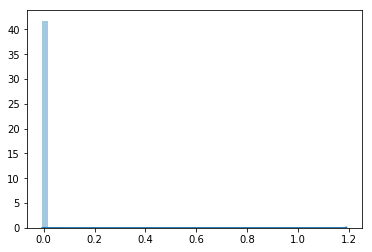

In [309]:
sns.distplot(if_[0][:])

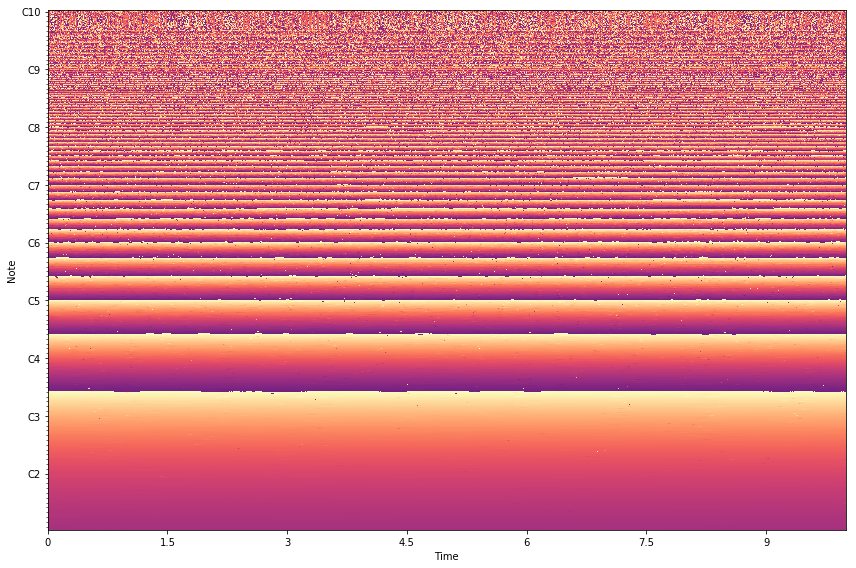

In [40]:
plt.figure(figsize=(12, 8))
# librosa.display.specshow(if_, y_axis='log', x_axis='time')
librosa.display.specshow(if_,sr=sr_resampled*2, x_axis='time', y_axis='cqt_note', bins_per_octave=bins_per_octave)
plt.tight_layout()

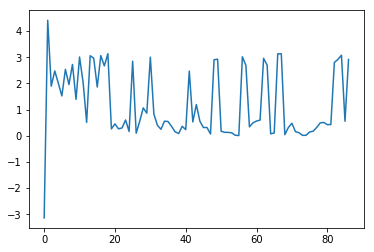

In [191]:
y_stft_phase.shape
if_ = ifFromPhase(y_stft_phase)
plt.plot(range(y_stft_phase.shape[1]), if_[10])
# 7//np.pi

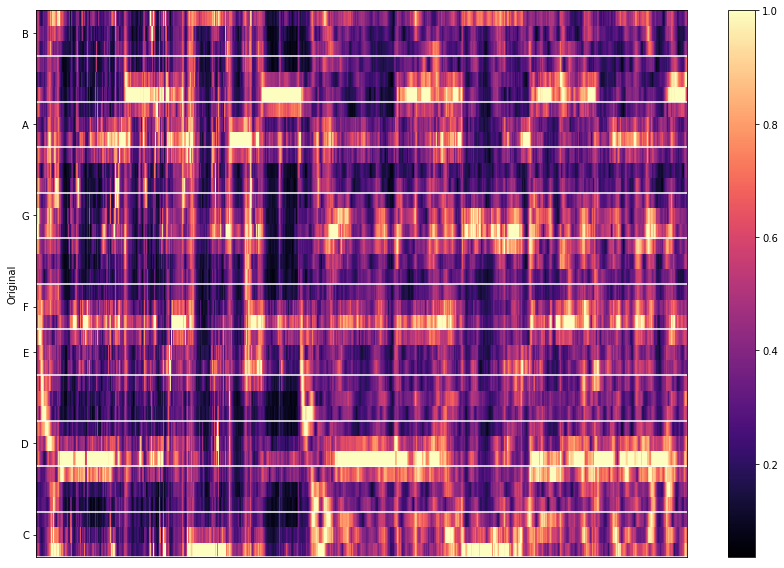

In [8]:
# k = 3
# res = 6
chroma_orig = librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=bins_per_octave, n_chroma=bins_per_octave)
plt.figure(figsize=(12, 8))
librosa.display.specshow(chroma_orig, y_axis='chroma', bins_per_octave=bins_per_octave)
plt.colorbar()
plt.ylabel('Original')
plt.hlines(y=range(12), xmin=0, xmax=3100, color='white')
plt.tight_layout()

In [192]:
k = 3
n_octaves = 9
nkeys = keys*k
permutation = np.array([j + octave*nkeys for j in range(nkeys) for octave in range(n_octaves)])
# permutation

In [193]:
y_cqt_abs_perm = y_cqt_abs[permutation,:]
y_cqt_abs_perm.shape

(324, 1034)

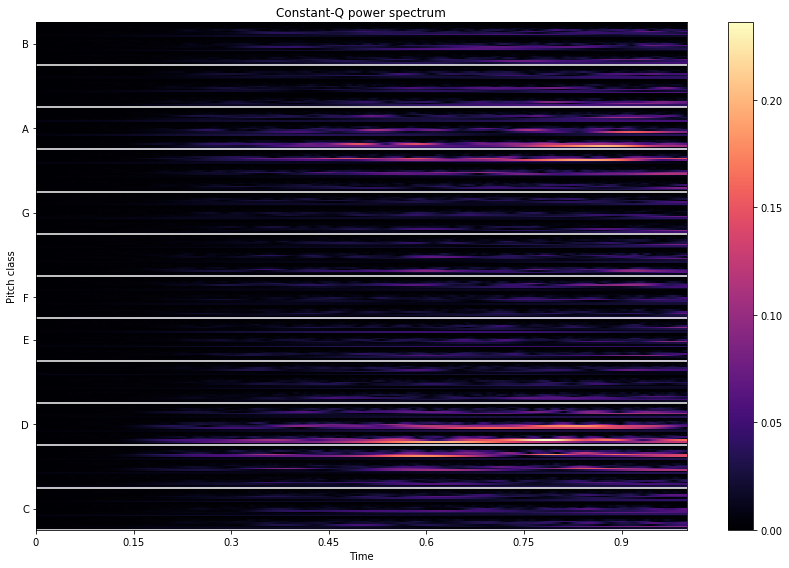

In [194]:
# res = 6
plt.figure(figsize=(12, 8))
display.specshow(np.power(y_cqt_abs_perm, 1/1.2), sr=sr_resampled*2, x_axis='time', y_axis='chroma', bins_per_octave=bins_per_octave*9) 
# cqt_note
plt.colorbar()
# plt.grid()
plt.hlines(y=range(12), xmin=0, xmax=30, color='white')
# plt.axhline(y=[1,2], xmin=0, xmax=3)
plt.title('Constant-Q power spectrum')
plt.tight_layout()

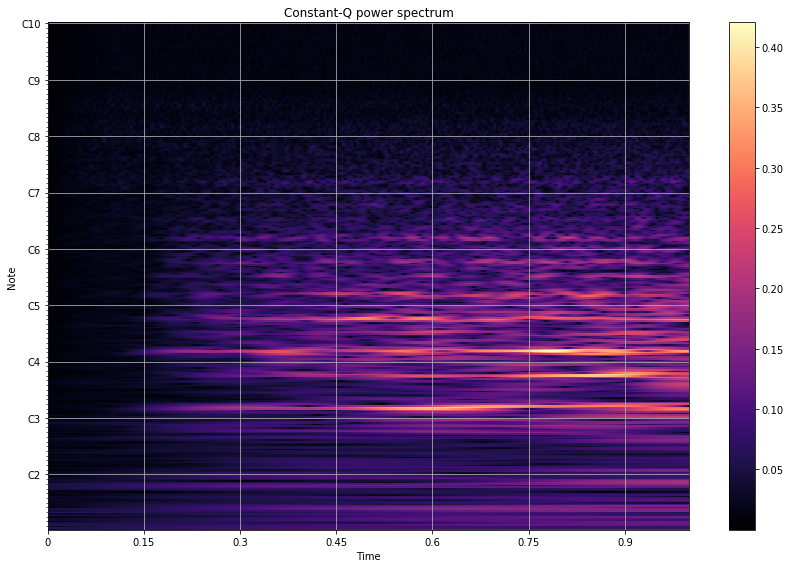

In [195]:
plt.figure(figsize=(12, 8))
display.specshow(np.power(y_cqt_abs, 1/2), sr=sr_resampled*2, x_axis='time', y_axis='cqt_note', bins_per_octave=bins_per_octave)
plt.colorbar()
plt.grid()
plt.title('Constant-Q power spectrum')
plt.tight_layout()

In [13]:
import sklearn.decomposition
T = sklearn.decomposition.MiniBatchDictionaryLearning(n_components=64)
scomps, sacts = librosa.decompose.decompose(y_stft_abs, transformer=T, sort=True)

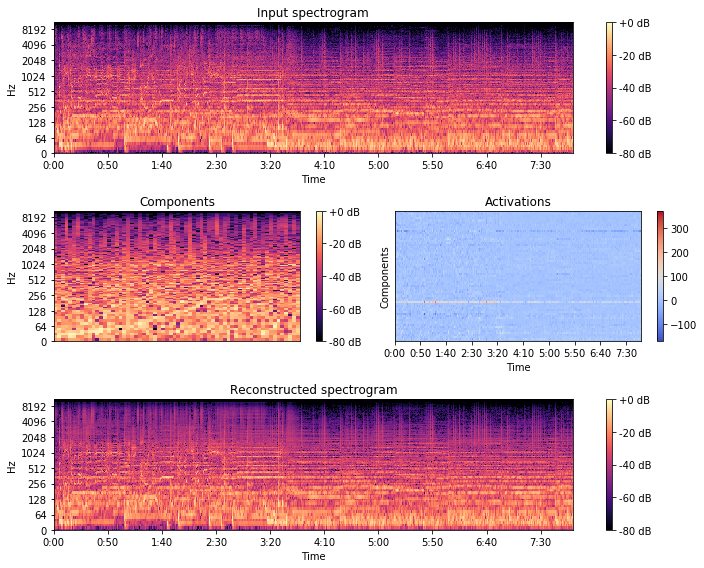

In [14]:
plt.figure(figsize=(10,8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(y_stft_abs, ref=np.max), y_axis='log', x_axis='time')
plt.title('Input spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.subplot(3, 2, 3)
librosa.display.specshow(librosa.amplitude_to_db(scomps, ref=np.max), y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Components')
plt.subplot(3, 2, 4)
librosa.display.specshow(sacts, x_axis='time')
plt.ylabel('Components')
plt.title('Activations')
plt.colorbar()
plt.subplot(3, 1, 3)
S_approx = scomps.dot(sacts)
librosa.display.specshow(librosa.amplitude_to_db(S_approx, ref=np.max), y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Reconstructed spectrogram')
plt.tight_layout()

In [15]:
T2 = sklearn.decomposition.MiniBatchDictionaryLearning(n_components=64)
mag, phase = librosa.magphase(y_cqt)
phase_abs = np.angle(phase)
scomps2, sacts2 = librosa.decompose.decompose(phase_abs, transformer=T2, sort=True)

In [16]:
np.angle(phase[10,0:10])
# y_stft[10,0:10]
# mag[10,0:10]

array([1.66587234e-04, 2.41512311e-01, 4.82861648e-01, 7.24174514e-01,
       9.65484501e-01, 1.20684949e+00, 1.44818268e+00, 1.68948158e+00,
       1.93082796e+00, 2.17216869e+00])

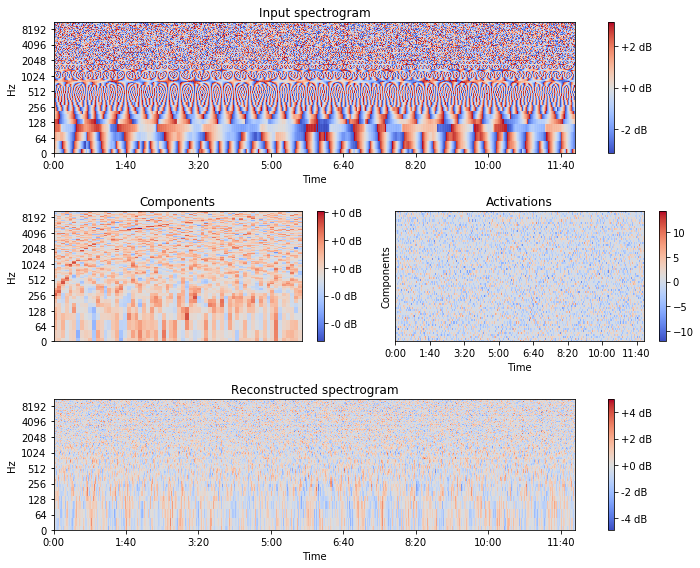

In [17]:
plt.figure(figsize=(10,8))
plt.subplot(3, 1, 1)
librosa.display.specshow(phase_abs, y_axis='log', x_axis='time')
plt.title('Input spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.subplot(3, 2, 3)
librosa.display.specshow(scomps2, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Components')
plt.subplot(3, 2, 4)
librosa.display.specshow(sacts2, x_axis='time')
plt.ylabel('Components')
plt.title('Activations')
plt.colorbar()
plt.subplot(3, 1, 3)
S_approx2 = scomps2.dot(sacts2)
librosa.display.specshow(S_approx2, y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Reconstructed spectrogram')
plt.tight_layout()


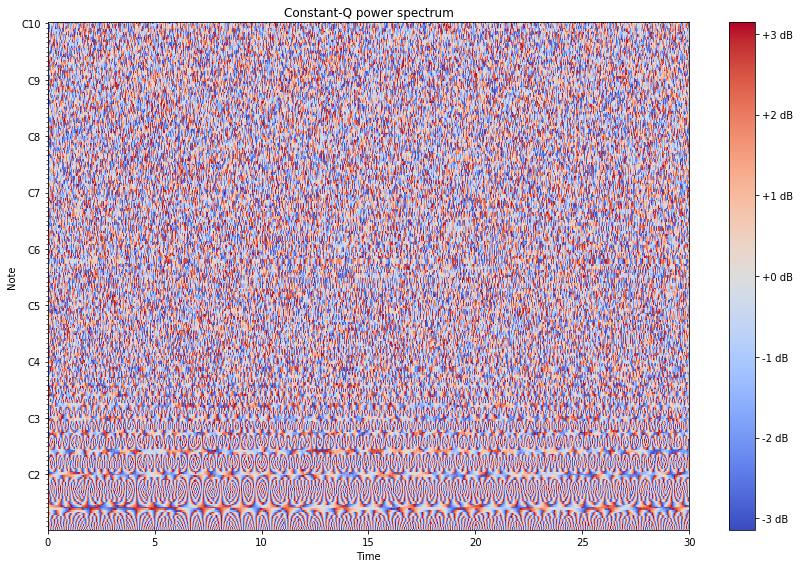

In [18]:
plt.figure(figsize=(12, 8))
display.specshow(phase_abs, sr=sr_resampled*2, x_axis='time', y_axis='cqt_note', bins_per_octave=bins_per_octave) 

plt.colorbar(format='%+2.0f dB')
# plt.grid()

plt.title('Constant-Q power spectrum')
plt.tight_layout()